In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.bert_conf
encoding_type = 'absolute'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.054735640823218 	 Validation loss: 2.005918225999606 	 
  1%|          | 574/57400 [01:56<2:28:57,  6.36it/s]
Epoch 2 	 Training loss: 1.9874629046028085 	 Validation loss: 1.9905389830217524 	 
  2%|▏         | 1148/57400 [03:40<2:16:00,  6.89it/s]
Epoch 3 	 Training loss: 1.9732929345622712 	 Validation loss: 1.98286584272223 	 
  3%|▎         | 1722/57400 [05:25<2:25:42,  6.37it/s]
Epoch 4 	 Training loss: 1.9680796145146733 	 Validation loss: 1.976640727560399 	 
  4%|▍         | 2296/57400 [07:12<2:37:50,  5.82it/s]
Epoch 5 	 Training loss: 1.9640117752842787 	 Validation loss: 1.9717146946211992 	 
  5%|▌         | 2870/57400 [08:58<2:34:29,  5.88it/s]
Epoch 6 	 Training loss: 1.960318544808165 	 Validation loss: 1.9756106037204548 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:43<2:13:25,  6.74it/s]
Epoch 7 	 Training loss: 1.9573599494708125 	 Validation loss: 1.9693103947881925 	 
  7%|▋         | 4018/57400 [12:29<2:25:08,  6.13it/s

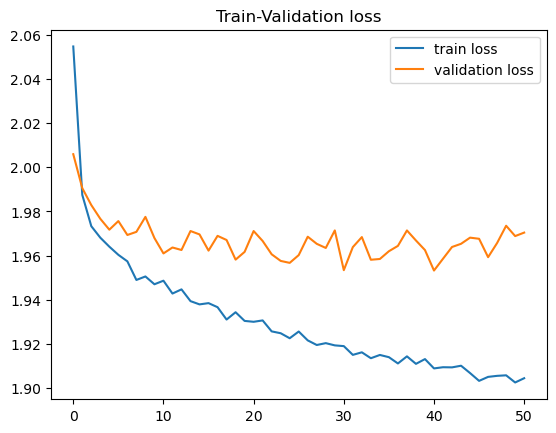

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_absolute_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load('bert_multitask_absolute_1'))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7184343434343434, 'precision': 0.7184343434343434, 'f1': 0.7184343434343435, 'accuracy': 0.7184343434343434}, 'as': {'recall': 0.7249022164276402, 'precision': 0.7249022164276402, 'f1': 0.7249022164276402, 'accuracy': 0.7249022164276402}, 'about': {'recall': 0.8418367346938775, 'precision': 0.8418367346938775, 'f1': 0.8418367346938774, 'accuracy': 0.8418367346938775}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7396593673965937, 'precision': 0.7396593673965937, 'f1': 0.7396593673965937, 'accuracy': 0.7396593673965937}, 'as': {'recall': 0.7222222222222222, 'precision': 0.7222222222222222, 'f1': 0.7222222222222222, 'accuracy': 0.7222222222222222}, 'about': {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821}, 'as': {'recall': 0.7277628032345014, 'precisio

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.058935512441376 	 Validation loss: 2.0137856653181174 	 
  1%|          | 574/57400 [01:42<2:28:37,  6.37it/s]
Epoch 2 	 Training loss: 1.996869651282706 	 Validation loss: 1.988383790193978 	 
  2%|▏         | 1148/57400 [03:24<2:38:56,  5.90it/s]
Epoch 3 	 Training loss: 1.981246549701026 	 Validation loss: 1.982185913344561 	 
  3%|▎         | 1722/57400 [05:07<2:29:30,  6.21it/s]
Epoch 4 	 Training loss: 1.9712095769440257 	 Validation loss: 1.9711665177749376 	 
  4%|▍         | 2296/57400 [06:51<2:29:15,  6.15it/s]
Epoch 5 	 Training loss: 1.9671331519449213 	 Validation loss: 1.9772122593249304 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:35<2:26:56,  6.18it/s]
Epoch 6 	 Training loss: 1.9643695443764797 	 Validation loss: 1.971831444966591 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:17<2:37:47,  5.70it/s]
Epoch 7 	 Training loss: 1.959882425306566 	 Validation loss: 1.977570527690952 	 

3 epoch without improveme

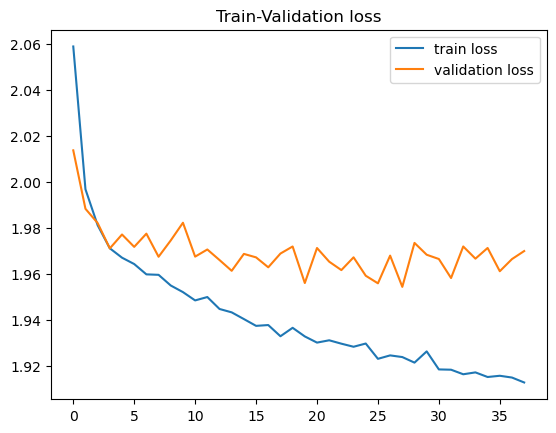

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_absolute_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6944444444444444, 'precision': 0.6944444444444444, 'f1': 0.6944444444444444, 'accuracy': 0.6944444444444444}, 'as': {'recall': 0.7235984354628422, 'precision': 0.7235984354628422, 'f1': 0.7235984354628422, 'accuracy': 0.7235984354628422}, 'about': {'recall': 0.826530612244898, 'precision': 0.826530612244898, 'f1': 0.826530612244898, 'accuracy': 0.826530612244898}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7201946472019465, 'precision': 0.7201946472019465, 'f1': 0.7201946472019465, 'accuracy': 0.7201946472019465}, 'as': {'recall': 0.7297979797979798, 'precision': 0.7297979797979798, 'f1': 0.7297979797979797, 'accuracy': 0.7297979797979798}, 'about': {'recall': 0.828125, 'precision': 0.828125, 'f1': 0.828125, 'accuracy': 0.828125}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6666666666666666, 'precision': 0.6666666666666666, 'f1': 0.6666666666666666, 'accuracy': 0.6666666666666666}, 'as': {'recall': 0.7169811320754716, 'precisio

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0554824591929073 	 Validation loss: 2.0153317188812516 	 
  1%|          | 574/57400 [01:42<2:37:34,  6.01it/s]
Epoch 2 	 Training loss: 1.9953446490008657 	 Validation loss: 1.990886025509592 	 
  2%|▏         | 1148/57400 [03:25<2:37:29,  5.95it/s]
Epoch 3 	 Training loss: 1.9790169617440228 	 Validation loss: 1.9803385875992856 	 
  3%|▎         | 1722/57400 [05:09<2:36:28,  5.93it/s]
Epoch 4 	 Training loss: 1.971493217795568 	 Validation loss: 1.9762783454636397 	 
  4%|▍         | 2296/57400 [06:52<2:49:12,  5.43it/s]
Epoch 5 	 Training loss: 1.9664190143658309 	 Validation loss: 1.9809477531303794 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:33<2:32:35,  5.96it/s]
Epoch 6 	 Training loss: 1.9626345445470113 	 Validation loss: 1.9733166856280828 	 
  6%|▌         | 3444/57400 [10:17<2:32:32,  5.90it/s]
Epoch 7 	 Training loss: 1.9594842139436808 	 Validation loss: 1.9738103292756162 	 

1 epoch without improvement
  7%|▋         | 401

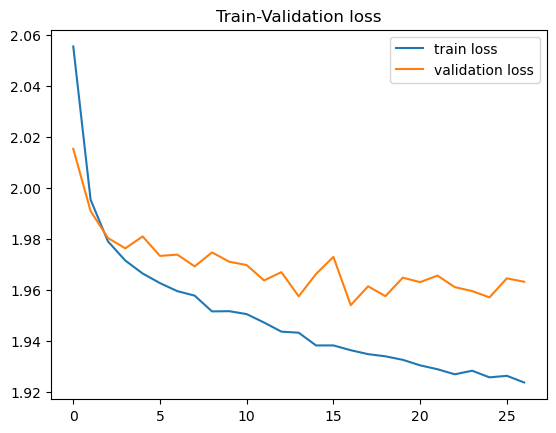

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='bert_multitask_absolute_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6906565656565656, 'precision': 0.6906565656565656, 'f1': 0.6906565656565656, 'accuracy': 0.6906565656565656}, 'as': {'recall': 0.727509778357236, 'precision': 0.727509778357236, 'f1': 0.727509778357236, 'accuracy': 0.727509778357236}, 'about': {'recall': 0.8303571428571429, 'precision': 0.8303571428571429, 'f1': 0.8303571428571429, 'accuracy': 0.8303571428571429}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}, 'as': {'recall': 0.7449494949494949, 'precision': 0.7449494949494949, 'f1': 0.7449494949494948, 'accuracy': 0.7449494949494949}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617}, 'as': 

In [17]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8329081632653061, 'precision': 0.8329081632653061, 'f1': 0.8329081632653061, 'accuracy': 0.8329081632653061}
Métricas etiqueta male: {'recall': 0.8402777777777778, 'precision': 0.8402777777777778, 'f1': 0.8402777777777778, 'accuracy': 0.8402777777777778}
Métricas etiqueta female:  {'recall': 0.8258333333333333, 'precision': 0.8258333333333333, 'f1': 0.8258333333333333, 'accuracy': 0.8258333333333333}

 to
Resultado global: {'recall': 0.7011784511784511, 'precision': 0.7011784511784511, 'f1': 0.7011784511784512, 'accuracy': 0.7011784511784511}
Métricas etiqueta male: {'recall': 0.732360097323601, 'precision': 0.732360097323601, 'f1': 0.732360097323601, 'accuracy': 0.732360097323601}
Métricas etiqueta female:  {'recall': 0.6675415573053368, 'precision': 0.6675415573053368, 'f1': 0.6675415573053368, 'accuracy': 0.6675415573053368}

 as
Resultado global: {'recall': 0.7253368100825728, 'precision': 0.7253368100825728, 'f1': 0.72533